# Imports

In [1]:
import sys
import os
from PIL import Image
from glob import glob
import math
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from tqdm import tqdm
from timm import create_model
import matplotlib.pyplot as plt

# Exploration

In [2]:
p1="/kaggle/input/deeplense/SpecificTest_06_A/Dataset/no_sub/no_sub_sim_100043654144385630537921390101531439263.npy"
p2="/kaggle/input/deeplense/SpecificTest_06_A/Dataset/cdm/cdm_sim_100034082227441687504290310179801063880.npy"
p3="/kaggle/input/deeplense/SpecificTest_06_A/Dataset/axion/axion_sim_100053750891322667723241922116446571210.npy"
arr = np.load(p3, allow_pickle=True)
print(arr[0].shape, arr[1])

(64, 64) 6.835932849583796e-23


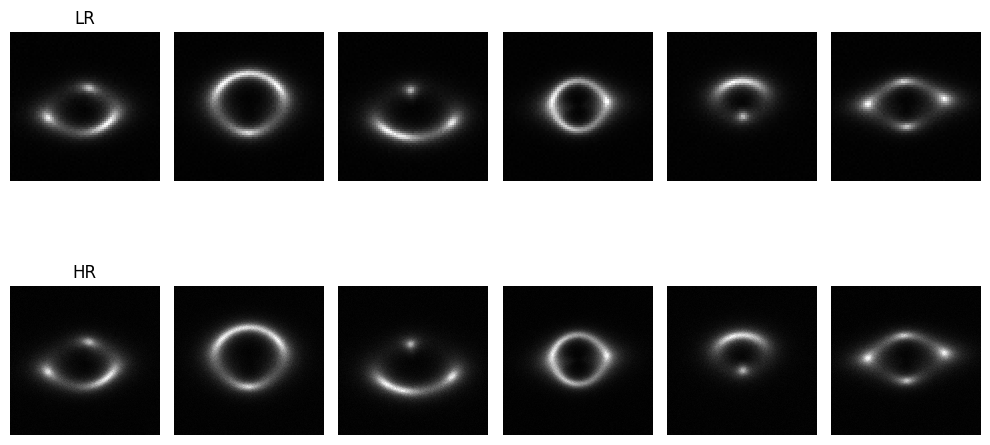

In [3]:
# Function to display images
def show_sample_images(dataset_path, class_names, num_samples=6):
    fig, axes = plt.subplots(len(class_names), num_samples, figsize=(10, 6))
    
    for i, class_name in enumerate(class_names):
        class_dir = os.path.join(dataset_path, class_name)
        files = [f for f in os.listdir(class_dir) if f.endswith(".npy")]
        
        for j in range(num_samples):
            img = np.load(os.path.join(class_dir, files[j]), allow_pickle=True)
            if class_name == "axion":
                img = img[0]
            img = img.squeeze()  # Remove channel dim (1, H, W) -> (H, W)
            axes[i, j].imshow(img, cmap="gray")
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(class_name)

    plt.tight_layout()
    plt.show()

# Show samples
class_namesB = ["LR", "HR"]
dataset_pathB = "/kaggle/input/deeplense/SpecificTest_06_B/Dataset"
show_sample_images(dataset_pathB, class_namesB)

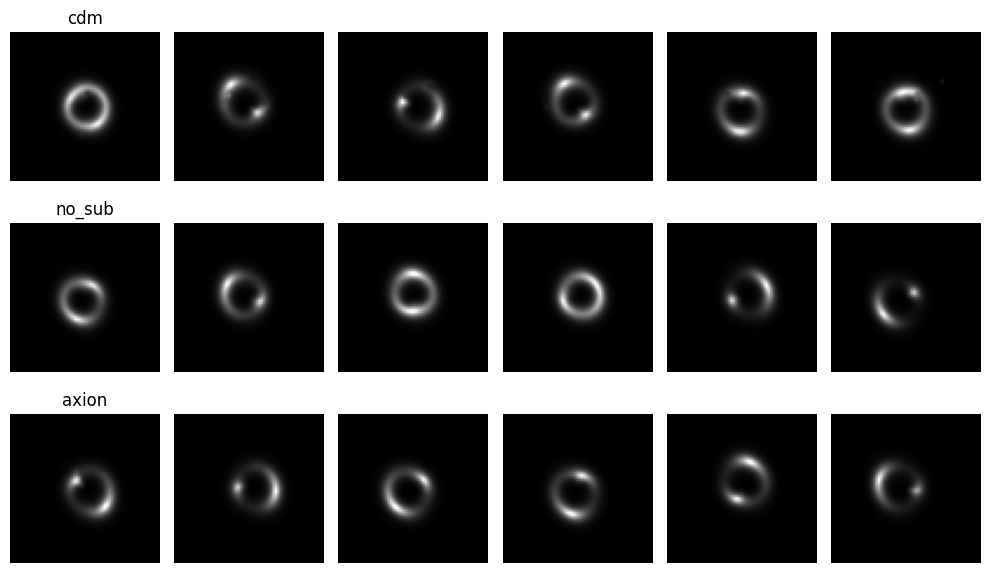

In [4]:
class_namesA = ["cdm", "no_sub", "axion"]
dataset_pathA = "/kaggle/input/deeplense/SpecificTest_06_A/Dataset"
show_sample_images(dataset_pathA, class_namesA)

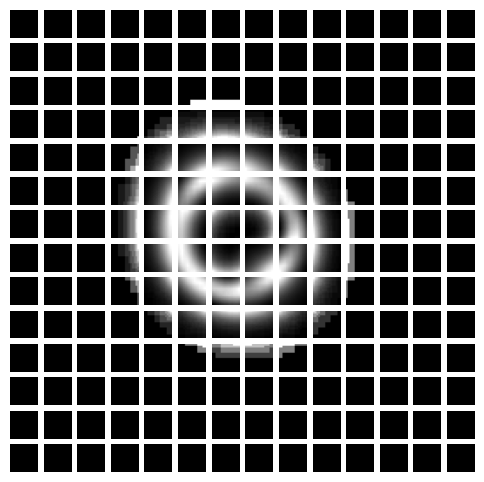

In [5]:
def image_to_patches(image, patch_size=16):
    """Convert a grayscale image into non-overlapping patches"""
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize to 224x224
        transforms.ToTensor(),          # Convert to Tensor
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize grayscale image
    ])

    img_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    batch_size, C, H, W = img_tensor.shape
    num_patches = (H // patch_size) * (W // patch_size)

    # Split into patches
    img_patches = img_tensor.unfold(2, patch_size, patch_size).unfold(3, patch_size, patch_size)
    img_patches = img_patches.contiguous().view(batch_size, num_patches, -1)  # Flatten patches

    return img_patches

# Load an example image (grayscale from .npy)
image_path = "/kaggle/input/deeplense/SpecificTest_06_A/Dataset/no_sub/no_sub_sim_100008917700138988486624773794898508448.npy"
image_array = np.load(image_path)  # Load .npy file
image_tensor = torch.tensor(image_array, dtype=torch.float32)  # Convert to tensor
image_tensor = (image_tensor - image_tensor.min()) / (image_tensor.max() - image_tensor.min())  # Normalize

# Convert to PIL image (for transformations)
from PIL import Image
image = Image.fromarray((image_tensor.numpy() * 255).astype(np.uint8))  # Convert back to uint8

# Process image into patches
img_patches = image_to_patches(image)

# Visualize the patches
plt.figure(figsize=(6, 6))
for i in range(14):
    for j in range(14):
        idx = i * 14 + j
        patch = img_patches[0, idx, :].view(1, 16, 16).squeeze(0).numpy()  # Convert back to 2D
        plt.subplot(14, 14, idx + 1)
        plt.imshow(patch, cmap="gray")  # Display as grayscale
        plt.axis('off')
plt.show()


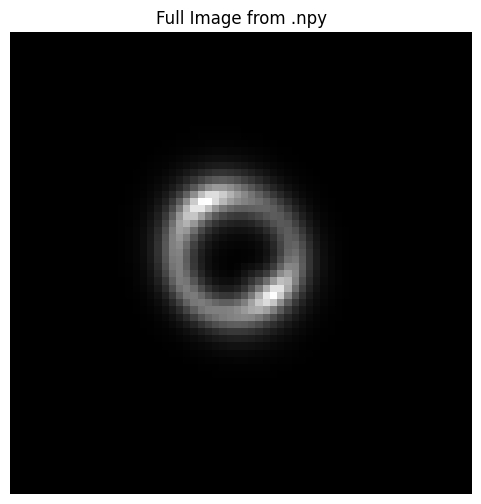

In [6]:
# Load the .npy file
image_path = "/kaggle/input/deeplense/SpecificTest_06_A/Dataset/no_sub/no_sub_sim_100008917700138988486624773794898508448.npy"
image_array = np.load(image_path)  # Load the image (assuming it's grayscale)

# Normalize the image for better visualization (optional)
image_array = (image_array - image_array.min()) / (image_array.max() - image_array.min())

# Plot the whole image
plt.figure(figsize=(6, 6))
plt.imshow(image_array, cmap="gray")  # Use grayscale colormap
plt.axis("off")  # Hide axes
plt.title("Full Image from .npy")
plt.show()

# DataLoader

In [7]:
class NPYDataset(Dataset):
    def __init__(self, npy_dir, transform=None):
        self.npy_files = npy_dir
        self.transform = transform

    def __len__(self):
        return len(self.npy_files)

    def __getitem__(self, idx):
        img = np.load(self.npy_files[idx])
        img = Image.fromarray(np.uint8(img * 255))

        if self.transform:
            img = self.transform(img)

        return img


In [8]:
train_transforms = transforms.Compose([
    # transforms.CenterCrop(100),
    transforms.Resize(150, Image.LANCZOS),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

val_transforms = transforms.Compose([
        transforms.Resize(150, Image.LANCZOS),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
])

In [9]:
dataset_root = "/kaggle/input/deeplense/SpecificTest_06_A/Dataset"

axion_files = sorted(glob(os.path.join(dataset_root, "axion", "*.npy")))
no_sub_files = sorted(glob(os.path.join(dataset_root, "no_sub", "*.npy")))
cdm_files = sorted(glob(os.path.join(dataset_root, "cdm", "*.npy")))

all_files = no_sub_files + axion_files + cdm_files
labels = [0] * len(no_sub_files) + [1] * len(axion_files) + [2] * len(cdm_files)

# First split: 90% train, 10% val (stratified)
train_files, val_files, train_labels, val_labels = train_test_split(
    all_files, labels, test_size=0.1, stratify=labels, random_state=42
)

# Filter out only `no_sub` samples from training set
no_sub_train_files = [f for f, l in zip(train_files, train_labels) if l == 0]
no_sub_val_files = [f for f, l in zip(val_files, val_labels) if l == 0]

# Train MAE only on no_sub_train_files
batch_size=256
train_dataset = NPYDataset(no_sub_train_files, train_transforms)
train_loader = DataLoader(train_dataset, batch_size=batch_size, num_workers=4, shuffle=True)

# Validation set for MAE (later used in classification also)
val_dataset = NPYDataset(no_sub_val_files, val_transforms)
val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=4, shuffle=False)

## Model Architecture

In [10]:
def print_trainable_parameters(model):
    trainable_params = 0
    all_param = 0
    for _, param in model.named_parameters():
        all_param += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(f"trainable params: {trainable_params} || all params: {all_param} || trainable%: {100 * trainable_params / all_param}")

In [11]:
class EncoderViT(nn.Module):
    def __init__(self, base="tiny", p=0.25):
        super(EncoderViT, self).__init__()

        modelss = create_model(f"vit_{base}_patch16_224", pretrained=True)
        modelss.patch_embed = nn.Identity()
        modelss.head = nn.Identity() # now output shape is embed_dim (tiny: 192, base: 768)
        self.set_dropout(modelss, p)

        # self.model.pos_embed = nn.Identity()  # Bypass position encoding in timm
        # Override `_pos_embed()` so ViT doesn’t add its own position embedding
        # def forward_pos_embed(x):
        #     return x 
        # self.model._pos_embed = forward_pos_embed

        self.encoder_blocks = modelss.blocks
        self.norm = modelss.norm

    def set_dropout(self, model, p):
        """Recursively set dropout probability in a model."""
        for name, module in model.named_modules():
            if isinstance(module, nn.Dropout):
                module.p = p

    def forward(self, x):
        for block in self.encoder_blocks:
            x = block(x)

        x = self.norm(x)

        return x

class MAEDecoder(nn.Module):
    def __init__(self, embed_dim=192, output_patch=256, num_layers=2, num_heads=6):
        super().__init__()

        # Transformer decoder layers
        self.decoder_blocks = nn.Sequential(*[
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dim_feedforward=embed_dim * 4)
            for _ in range(num_layers)
        ])
        
        self.final_layer = nn.Linear(embed_dim, output_patch)  # Output patch embeddings

    def forward(self, x):
        x = self.decoder_blocks(x)  # Apply transformer decoder layers
        return self.final_layer(x)  # Shape: [batch_size, num_patches, embed_dim]

# Define the Encoder (ViT model)
class MAEViT(nn.Module):
    def __init__(self, base="tiny", input_dim=256, embed_dim=192, num_patches=196, mask_ratio=0.75, p=0.25):
        super().__init__()
        self.embed_dim = embed_dim
        self.embedInput = nn.Linear(input_dim, self.embed_dim)
        self.encoder = EncoderViT(base=base, p=p)
        self.decoder = MAEDecoder(output_patch=input_dim, embed_dim=embed_dim)

        self.mask_ratio = mask_ratio
        self.num_patches = num_patches
        self.num_masked = int(self.num_patches * self.mask_ratio)
        self.mask_token = nn.Parameter(torch.randn(1, 1, embed_dim))  # Learnable mask token

        # Compute and store full position encoding ONCE
        self.register_buffer("full_position_encoding", self.sinusoidal_position_encoding(num_patches, self.embed_dim).unsqueeze(0))

    def forward(self, x):
        batch_size = x.shape[0]
        
        # Apply masking
        visible_patches, masked_indices, visible_indices = self.random_masking(x)

        visible_pos_encoding = torch.gather(
            self.full_position_encoding.expand(x.shape[0], -1, -1), dim=1, 
            index=visible_indices.unsqueeze(-1).expand(-1, -1, self.embed_dim)
        )
        x = self.embedInput(visible_patches) + visible_pos_encoding # (bs, visible_patches, embed_dim)

        # Encode only visible patches
        encoded = self.encoder(x)

        # Decode
        ## masking
        ### Create a full set of tokens filled with MASK tokens
        full_tokens = self.mask_token.repeat(batch_size, self.num_patches, 1)
        ### Insert the encoded visible patches into the correct positions
        full_tokens.scatter_(1, visible_indices.unsqueeze(-1).expand(-1, -1, encoded.shape[-1]), encoded)
        ### Apply position encoding to all patches (both visible and masked)
        full_pos_encoding = self.full_position_encoding.expand(batch_size, -1, -1)  # Shape: [batch_size, 196, embed_dim]
        full_tokens = full_tokens + full_pos_encoding

        reconstructed = self.decoder(full_tokens)

        return reconstructed, masked_indices

    def sinusoidal_position_encoding(self, num_patches, embed_dim):
        position = torch.arange(num_patches).unsqueeze(1)  # Shape: (num_patches, 1)
        div_term = torch.exp(torch.arange(0, embed_dim, 2) * (-math.log(10000.0) / embed_dim))

        pe = torch.zeros(num_patches, embed_dim)
        pe[:, 1::2] = torch.sin(position * div_term)
        pe[:, 0::2] = torch.cos(position * div_term)

        return pe  # Shape: (num_patches, embed_dim)

    def random_masking(self, x):
        batch_size, num_patches, dim = x.shape

        # Shuffle patch indices
        indices = torch.rand(batch_size, num_patches).argsort(dim=1).to(x.device)
    
        # Keep only a fraction of patches
        visible_indices = indices[:, self.num_masked:]
        masked_indices = indices[:, :self.num_masked]
    
        # Select the visible patches
        visible_patches = torch.gather(x, dim=1, index=visible_indices.unsqueeze(-1).expand(-1, -1, dim))
    
        return visible_patches, masked_indices, visible_indices


## Training

In [12]:
def image_to_patches(img_tensor, patch_size=16):
    _, C, H, W = img_tensor.shape
    num_patches = (H // patch_size) * (W // patch_size)

    # Split into patches
    img_patches = img_tensor.unfold(2, patch_size, patch_size) # [1, 1, 224, 224] -> [1, 1, 14, 224, 16]
    img_patches = img_patches.unfold(3, patch_size, patch_size)  # [1, 1, 14, 224, 16] -> [1, 1, 14, 14, 16, 16]
    img_patches = img_patches.contiguous().view(-1, num_patches, patch_size * patch_size)  # Flatten patches [1, 1, 14, 14, 16, 16] -> [1, 196, 256]

    return img_patches

masked patches:  168
visible patches:  57


model.safetensors:   0%|          | 0.00/22.9M [00:00<?, ?B/s]

trainable params: 6267364 || all params: 6267364 || trainable%: 100.0


Epoch 1/250: 100%|██████████| 12/12 [00:08<00:00,  1.34it/s]


Epoch [1/250] | Train Loss: 0.1600 | Val Loss: 0.0834
Model Saved (Best Validation loss)


Epoch 2/250: 100%|██████████| 12/12 [00:02<00:00,  5.40it/s]


Epoch [2/250] | Train Loss: 0.0559 | Val Loss: 0.0473
Model Saved (Best Validation loss)


Epoch 3/250: 100%|██████████| 12/12 [00:02<00:00,  5.29it/s]


Epoch [3/250] | Train Loss: 0.0514 | Val Loss: 0.0462
Model Saved (Best Validation loss)


Epoch 4/250: 100%|██████████| 12/12 [00:02<00:00,  5.03it/s]


Epoch [4/250] | Train Loss: 0.0488 | Val Loss: 0.0452
Model Saved (Best Validation loss)


Epoch 5/250: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


Epoch [5/250] | Train Loss: 0.0466 | Val Loss: 0.0448
Model Saved (Best Validation loss)


Epoch 6/250: 100%|██████████| 12/12 [00:02<00:00,  4.59it/s]


Epoch [6/250] | Train Loss: 0.0450 | Val Loss: 0.0434
Model Saved (Best Validation loss)


Epoch 7/250: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Epoch [7/250] | Train Loss: 0.0434 | Val Loss: 0.0423
Model Saved (Best Validation loss)


Epoch 8/250: 100%|██████████| 12/12 [00:02<00:00,  5.48it/s]


Epoch [8/250] | Train Loss: 0.0423 | Val Loss: 0.0416
Model Saved (Best Validation loss)


Epoch 9/250: 100%|██████████| 12/12 [00:02<00:00,  5.57it/s]


Epoch [9/250] | Train Loss: 0.0419 | Val Loss: 0.0419


Epoch 10/250: 100%|██████████| 12/12 [00:02<00:00,  5.35it/s]


Epoch [10/250] | Train Loss: 0.0415 | Val Loss: 0.0414
Model Saved (Best Validation loss)


Epoch 11/250: 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]


Epoch [11/250] | Train Loss: 0.0412 | Val Loss: 0.0411
Model Saved (Best Validation loss)


Epoch 12/250: 100%|██████████| 12/12 [00:02<00:00,  4.79it/s]


Epoch [12/250] | Train Loss: 0.0411 | Val Loss: 0.0410
Model Saved (Best Validation loss)


Epoch 13/250: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Epoch [13/250] | Train Loss: 0.0408 | Val Loss: 0.0411


Epoch 14/250: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Epoch [14/250] | Train Loss: 0.0407 | Val Loss: 0.0402
Model Saved (Best Validation loss)


Epoch 15/250: 100%|██████████| 12/12 [00:02<00:00,  5.36it/s]


Epoch [15/250] | Train Loss: 0.0406 | Val Loss: 0.0407


Epoch 16/250: 100%|██████████| 12/12 [00:02<00:00,  5.50it/s]


Epoch [16/250] | Train Loss: 0.0405 | Val Loss: 0.0403


Epoch 17/250: 100%|██████████| 12/12 [00:02<00:00,  5.25it/s]


Epoch [17/250] | Train Loss: 0.0404 | Val Loss: 0.0408


Epoch 18/250: 100%|██████████| 12/12 [00:02<00:00,  5.53it/s]


Epoch [18/250] | Train Loss: 0.0403 | Val Loss: 0.0405


Epoch 19/250: 100%|██████████| 12/12 [00:02<00:00,  4.75it/s]


Epoch [19/250] | Train Loss: 0.0403 | Val Loss: 0.0400
Model Saved (Best Validation loss)


Epoch 20/250: 100%|██████████| 12/12 [00:02<00:00,  5.51it/s]


Epoch [20/250] | Train Loss: 0.0402 | Val Loss: 0.0399
Model Saved (Best Validation loss)


Epoch 21/250: 100%|██████████| 12/12 [00:02<00:00,  4.77it/s]


Epoch [21/250] | Train Loss: 0.0402 | Val Loss: 0.0400


Epoch 22/250: 100%|██████████| 12/12 [00:02<00:00,  5.46it/s]


Epoch [22/250] | Train Loss: 0.0401 | Val Loss: 0.0402


Epoch 23/250: 100%|██████████| 12/12 [00:02<00:00,  5.47it/s]


Epoch [23/250] | Train Loss: 0.0400 | Val Loss: 0.0401


Epoch 24/250: 100%|██████████| 12/12 [00:02<00:00,  5.53it/s]


Epoch [24/250] | Train Loss: 0.0400 | Val Loss: 0.0400


Epoch 25/250: 100%|██████████| 12/12 [00:02<00:00,  5.23it/s]


Epoch [25/250] | Train Loss: 0.0399 | Val Loss: 0.0399


Epoch 26/250: 100%|██████████| 12/12 [00:02<00:00,  5.08it/s]


Epoch [26/250] | Train Loss: 0.0399 | Val Loss: 0.0399


Epoch 27/250: 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]


Epoch [27/250] | Train Loss: 0.0399 | Val Loss: 0.0398
Model Saved (Best Validation loss)


Epoch 28/250: 100%|██████████| 12/12 [00:02<00:00,  4.20it/s]


Epoch [28/250] | Train Loss: 0.0399 | Val Loss: 0.0397
Model Saved (Best Validation loss)


Epoch 29/250: 100%|██████████| 12/12 [00:02<00:00,  5.38it/s]


Epoch [29/250] | Train Loss: 0.0398 | Val Loss: 0.0399


Epoch 30/250: 100%|██████████| 12/12 [00:02<00:00,  5.47it/s]


Epoch [30/250] | Train Loss: 0.0398 | Val Loss: 0.0396
Model Saved (Best Validation loss)


Epoch 31/250: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Epoch [31/250] | Train Loss: 0.0398 | Val Loss: 0.0400


Epoch 32/250: 100%|██████████| 12/12 [00:02<00:00,  5.37it/s]


Epoch [32/250] | Train Loss: 0.0398 | Val Loss: 0.0397


Epoch 33/250: 100%|██████████| 12/12 [00:02<00:00,  5.38it/s]


Epoch [33/250] | Train Loss: 0.0398 | Val Loss: 0.0398


Epoch 34/250: 100%|██████████| 12/12 [00:02<00:00,  4.99it/s]


Epoch [34/250] | Train Loss: 0.0397 | Val Loss: 0.0397


Epoch 35/250: 100%|██████████| 12/12 [00:02<00:00,  5.39it/s]


Epoch [35/250] | Train Loss: 0.0397 | Val Loss: 0.0398


Epoch 36/250: 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]


Epoch [36/250] | Train Loss: 0.0397 | Val Loss: 0.0399


Epoch 37/250: 100%|██████████| 12/12 [00:02<00:00,  5.39it/s]


Epoch [37/250] | Train Loss: 0.0397 | Val Loss: 0.0401


Epoch 38/250: 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]


Epoch [38/250] | Train Loss: 0.0397 | Val Loss: 0.0396
Model Saved (Best Validation loss)


Epoch 39/250: 100%|██████████| 12/12 [00:02<00:00,  5.55it/s]


Epoch [39/250] | Train Loss: 0.0397 | Val Loss: 0.0398


Epoch 40/250: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Epoch [40/250] | Train Loss: 0.0397 | Val Loss: 0.0396


Epoch 41/250: 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]


Epoch [41/250] | Train Loss: 0.0397 | Val Loss: 0.0396


Epoch 42/250: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Epoch [42/250] | Train Loss: 0.0397 | Val Loss: 0.0398


Epoch 43/250: 100%|██████████| 12/12 [00:02<00:00,  4.89it/s]


Epoch [43/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 44/250: 100%|██████████| 12/12 [00:03<00:00,  3.42it/s]


Epoch [44/250] | Train Loss: 0.0397 | Val Loss: 0.0398


Epoch 45/250: 100%|██████████| 12/12 [00:02<00:00,  5.48it/s]


Epoch [45/250] | Train Loss: 0.0397 | Val Loss: 0.0396


Epoch 46/250: 100%|██████████| 12/12 [00:02<00:00,  5.49it/s]


Epoch [46/250] | Train Loss: 0.0397 | Val Loss: 0.0397


Epoch 47/250: 100%|██████████| 12/12 [00:02<00:00,  5.20it/s]


Epoch [47/250] | Train Loss: 0.0397 | Val Loss: 0.0396


Epoch 48/250: 100%|██████████| 12/12 [00:02<00:00,  4.66it/s]


Epoch [48/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 49/250: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Epoch [49/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 50/250: 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]


Epoch [50/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 51/250: 100%|██████████| 12/12 [00:02<00:00,  5.66it/s]


Epoch [51/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 52/250: 100%|██████████| 12/12 [00:02<00:00,  4.88it/s]


Epoch [52/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 53/250: 100%|██████████| 12/12 [00:02<00:00,  4.70it/s]


Epoch [53/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 54/250: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Epoch [54/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 55/250: 100%|██████████| 12/12 [00:02<00:00,  5.47it/s]


Epoch [55/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 56/250: 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]


Epoch [56/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 57/250: 100%|██████████| 12/12 [00:02<00:00,  5.48it/s]


Epoch [57/250] | Train Loss: 0.0396 | Val Loss: 0.0396
Model Saved (Best Validation loss)


Epoch 58/250: 100%|██████████| 12/12 [00:02<00:00,  5.57it/s]


Epoch [58/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 59/250: 100%|██████████| 12/12 [00:02<00:00,  5.41it/s]


Epoch [59/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 60/250: 100%|██████████| 12/12 [00:02<00:00,  4.04it/s]


Epoch [60/250] | Train Loss: 0.0396 | Val Loss: 0.0396
Model Saved (Best Validation loss)


Epoch 61/250: 100%|██████████| 12/12 [00:02<00:00,  4.09it/s]


Epoch [61/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 62/250: 100%|██████████| 12/12 [00:02<00:00,  4.86it/s]


Epoch [62/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 63/250: 100%|██████████| 12/12 [00:02<00:00,  5.56it/s]


Epoch [63/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 64/250: 100%|██████████| 12/12 [00:02<00:00,  5.50it/s]


Epoch [64/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 65/250: 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]


Epoch [65/250] | Train Loss: 0.0396 | Val Loss: 0.0396
Model Saved (Best Validation loss)


Epoch 66/250: 100%|██████████| 12/12 [00:02<00:00,  5.50it/s]


Epoch [66/250] | Train Loss: 0.0397 | Val Loss: 0.0399


Epoch 67/250: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Epoch [67/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 68/250: 100%|██████████| 12/12 [00:02<00:00,  5.35it/s]


Epoch [68/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 69/250: 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]


Epoch [69/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 70/250: 100%|██████████| 12/12 [00:02<00:00,  5.52it/s]


Epoch [70/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 71/250: 100%|██████████| 12/12 [00:02<00:00,  5.39it/s]


Epoch [71/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 72/250: 100%|██████████| 12/12 [00:02<00:00,  5.38it/s]


Epoch [72/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 73/250: 100%|██████████| 12/12 [00:02<00:00,  5.12it/s]


Epoch [73/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 74/250: 100%|██████████| 12/12 [00:02<00:00,  5.48it/s]


Epoch [74/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 75/250: 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]


Epoch [75/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 76/250: 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]


Epoch [76/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 77/250: 100%|██████████| 12/12 [00:02<00:00,  5.53it/s]


Epoch [77/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 78/250: 100%|██████████| 12/12 [00:02<00:00,  5.51it/s]


Epoch [78/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 79/250: 100%|██████████| 12/12 [00:02<00:00,  5.51it/s]


Epoch [79/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 80/250: 100%|██████████| 12/12 [00:02<00:00,  5.57it/s]


Epoch [80/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 81/250: 100%|██████████| 12/12 [00:02<00:00,  5.40it/s]


Epoch [81/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 82/250: 100%|██████████| 12/12 [00:02<00:00,  5.46it/s]


Epoch [82/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 83/250: 100%|██████████| 12/12 [00:02<00:00,  4.06it/s]


Epoch [83/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 84/250: 100%|██████████| 12/12 [00:02<00:00,  5.53it/s]


Epoch [84/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 85/250: 100%|██████████| 12/12 [00:02<00:00,  5.58it/s]


Epoch [85/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 86/250: 100%|██████████| 12/12 [00:02<00:00,  5.55it/s]


Epoch [86/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 87/250: 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]


Epoch [87/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 88/250: 100%|██████████| 12/12 [00:02<00:00,  5.38it/s]


Epoch [88/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 89/250: 100%|██████████| 12/12 [00:02<00:00,  5.48it/s]


Epoch [89/250] | Train Loss: 0.0397 | Val Loss: 0.0397


Epoch 90/250: 100%|██████████| 12/12 [00:02<00:00,  5.34it/s]


Epoch [90/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 91/250: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Epoch [91/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 92/250: 100%|██████████| 12/12 [00:02<00:00,  5.40it/s]


Epoch [92/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 93/250: 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]


Epoch [93/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 94/250: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Epoch [94/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 95/250: 100%|██████████| 12/12 [00:02<00:00,  5.37it/s]


Epoch [95/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 96/250: 100%|██████████| 12/12 [00:02<00:00,  5.62it/s]


Epoch [96/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 97/250: 100%|██████████| 12/12 [00:02<00:00,  5.49it/s]


Epoch [97/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 98/250: 100%|██████████| 12/12 [00:02<00:00,  4.44it/s]


Epoch [98/250] | Train Loss: 0.0395 | Val Loss: 0.0397


Epoch 99/250: 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]


Epoch [99/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 100/250: 100%|██████████| 12/12 [00:02<00:00,  5.56it/s]


Epoch [100/250] | Train Loss: 0.0397 | Val Loss: 0.0397


Epoch 101/250: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Epoch [101/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 102/250: 100%|██████████| 12/12 [00:02<00:00,  5.47it/s]


Epoch [102/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 103/250: 100%|██████████| 12/12 [00:02<00:00,  5.41it/s]


Epoch [103/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 104/250: 100%|██████████| 12/12 [00:02<00:00,  5.29it/s]


Epoch [104/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 105/250: 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]


Epoch [105/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 106/250: 100%|██████████| 12/12 [00:02<00:00,  4.61it/s]


Epoch [106/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 107/250: 100%|██████████| 12/12 [00:02<00:00,  5.59it/s]


Epoch [107/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 108/250: 100%|██████████| 12/12 [00:02<00:00,  4.91it/s]


Epoch [108/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 109/250: 100%|██████████| 12/12 [00:02<00:00,  5.48it/s]


Epoch [109/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 110/250: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Epoch [110/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 111/250: 100%|██████████| 12/12 [00:02<00:00,  5.28it/s]


Epoch [111/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 112/250: 100%|██████████| 12/12 [00:02<00:00,  5.58it/s]


Epoch [112/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 113/250: 100%|██████████| 12/12 [00:02<00:00,  5.34it/s]


Epoch [113/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 114/250: 100%|██████████| 12/12 [00:02<00:00,  5.28it/s]


Epoch [114/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 115/250: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Epoch [115/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 116/250: 100%|██████████| 12/12 [00:02<00:00,  5.29it/s]


Epoch [116/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 117/250: 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]


Epoch [117/250] | Train Loss: 0.0395 | Val Loss: 0.0398


Epoch 118/250: 100%|██████████| 12/12 [00:02<00:00,  5.32it/s]


Epoch [118/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 119/250: 100%|██████████| 12/12 [00:02<00:00,  4.67it/s]


Epoch [119/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 120/250: 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]


Epoch [120/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 121/250: 100%|██████████| 12/12 [00:02<00:00,  4.34it/s]


Epoch [121/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 122/250: 100%|██████████| 12/12 [00:03<00:00,  3.61it/s]


Epoch [122/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 123/250: 100%|██████████| 12/12 [00:02<00:00,  5.54it/s]


Epoch [123/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 124/250: 100%|██████████| 12/12 [00:02<00:00,  5.37it/s]


Epoch [124/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 125/250: 100%|██████████| 12/12 [00:02<00:00,  4.69it/s]


Epoch [125/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 126/250: 100%|██████████| 12/12 [00:02<00:00,  4.87it/s]


Epoch [126/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 127/250: 100%|██████████| 12/12 [00:02<00:00,  5.50it/s]


Epoch [127/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 128/250: 100%|██████████| 12/12 [00:02<00:00,  5.50it/s]


Epoch [128/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 129/250: 100%|██████████| 12/12 [00:05<00:00,  2.14it/s]


Epoch [129/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 130/250: 100%|██████████| 12/12 [00:02<00:00,  5.56it/s]


Epoch [130/250] | Train Loss: 0.0395 | Val Loss: 0.0397


Epoch 131/250: 100%|██████████| 12/12 [00:02<00:00,  5.70it/s]


Epoch [131/250] | Train Loss: 0.0395 | Val Loss: 0.0396


Epoch 132/250: 100%|██████████| 12/12 [00:02<00:00,  5.16it/s]


Epoch [132/250] | Train Loss: 0.0396 | Val Loss: 0.0396
Model Saved (Best Validation loss)


Epoch 133/250: 100%|██████████| 12/12 [00:02<00:00,  4.70it/s]


Epoch [133/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 134/250: 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Epoch [134/250] | Train Loss: 0.0396 | Val Loss: 0.0396
Model Saved (Best Validation loss)


Epoch 135/250: 100%|██████████| 12/12 [00:02<00:00,  5.52it/s]


Epoch [135/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 136/250: 100%|██████████| 12/12 [00:02<00:00,  5.56it/s]


Epoch [136/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 137/250: 100%|██████████| 12/12 [00:02<00:00,  4.93it/s]


Epoch [137/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 138/250: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Epoch [138/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 139/250: 100%|██████████| 12/12 [00:02<00:00,  4.79it/s]


Epoch [139/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 140/250: 100%|██████████| 12/12 [00:02<00:00,  5.28it/s]


Epoch [140/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 141/250: 100%|██████████| 12/12 [00:02<00:00,  5.50it/s]


Epoch [141/250] | Train Loss: 0.0396 | Val Loss: 0.0395
Model Saved (Best Validation loss)


Epoch 142/250: 100%|██████████| 12/12 [00:02<00:00,  5.69it/s]


Epoch [142/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 143/250: 100%|██████████| 12/12 [00:02<00:00,  5.26it/s]


Epoch [143/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 144/250: 100%|██████████| 12/12 [00:02<00:00,  5.58it/s]


Epoch [144/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 145/250: 100%|██████████| 12/12 [00:02<00:00,  4.44it/s]


Epoch [145/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 146/250: 100%|██████████| 12/12 [00:02<00:00,  5.56it/s]


Epoch [146/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 147/250: 100%|██████████| 12/12 [00:02<00:00,  5.38it/s]


Epoch [147/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 148/250: 100%|██████████| 12/12 [00:02<00:00,  5.35it/s]


Epoch [148/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 149/250: 100%|██████████| 12/12 [00:02<00:00,  5.40it/s]


Epoch [149/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 150/250: 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]


Epoch [150/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 151/250: 100%|██████████| 12/12 [00:02<00:00,  5.25it/s]


Epoch [151/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 152/250: 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]


Epoch [152/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 153/250: 100%|██████████| 12/12 [00:02<00:00,  4.64it/s]


Epoch [153/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 154/250: 100%|██████████| 12/12 [00:02<00:00,  5.46it/s]


Epoch [154/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 155/250: 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]


Epoch [155/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 156/250: 100%|██████████| 12/12 [00:02<00:00,  5.57it/s]


Epoch [156/250] | Train Loss: 0.0395 | Val Loss: 0.0397


Epoch 157/250: 100%|██████████| 12/12 [00:02<00:00,  5.37it/s]


Epoch [157/250] | Train Loss: 0.0395 | Val Loss: 0.0396


Epoch 158/250: 100%|██████████| 12/12 [00:02<00:00,  5.38it/s]


Epoch [158/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 159/250: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Epoch [159/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 160/250: 100%|██████████| 12/12 [00:04<00:00,  2.77it/s]


Epoch [160/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 161/250: 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]


Epoch [161/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 162/250: 100%|██████████| 12/12 [00:02<00:00,  5.25it/s]


Epoch [162/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 163/250: 100%|██████████| 12/12 [00:02<00:00,  5.40it/s]


Epoch [163/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 164/250: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Epoch [164/250] | Train Loss: 0.0396 | Val Loss: 0.0395


Epoch 165/250: 100%|██████████| 12/12 [00:02<00:00,  5.32it/s]


Epoch [165/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 166/250: 100%|██████████| 12/12 [00:02<00:00,  5.42it/s]


Epoch [166/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 167/250: 100%|██████████| 12/12 [00:02<00:00,  5.46it/s]


Epoch [167/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 168/250: 100%|██████████| 12/12 [00:05<00:00,  2.19it/s]


Epoch [168/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 169/250: 100%|██████████| 12/12 [00:02<00:00,  4.70it/s]


Epoch [169/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 170/250: 100%|██████████| 12/12 [00:02<00:00,  5.55it/s]


Epoch [170/250] | Train Loss: 0.0396 | Val Loss: 0.0395


Epoch 171/250: 100%|██████████| 12/12 [00:02<00:00,  5.24it/s]


Epoch [171/250] | Train Loss: 0.0395 | Val Loss: 0.0397


Epoch 172/250: 100%|██████████| 12/12 [00:02<00:00,  5.38it/s]


Epoch [172/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 173/250: 100%|██████████| 12/12 [00:02<00:00,  5.25it/s]


Epoch [173/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 174/250: 100%|██████████| 12/12 [00:02<00:00,  5.29it/s]


Epoch [174/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 175/250: 100%|██████████| 12/12 [00:05<00:00,  2.31it/s]


Epoch [175/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 176/250: 100%|██████████| 12/12 [00:02<00:00,  4.78it/s]


Epoch [176/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 177/250: 100%|██████████| 12/12 [00:02<00:00,  5.38it/s]


Epoch [177/250] | Train Loss: 0.0395 | Val Loss: 0.0396


Epoch 178/250: 100%|██████████| 12/12 [00:02<00:00,  5.38it/s]


Epoch [178/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 179/250: 100%|██████████| 12/12 [00:02<00:00,  5.34it/s]


Epoch [179/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 180/250: 100%|██████████| 12/12 [00:02<00:00,  5.30it/s]


Epoch [180/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 181/250: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Epoch [181/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 182/250: 100%|██████████| 12/12 [00:02<00:00,  5.47it/s]


Epoch [182/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 183/250: 100%|██████████| 12/12 [00:02<00:00,  4.22it/s]


Epoch [183/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 184/250: 100%|██████████| 12/12 [00:02<00:00,  5.52it/s]


Epoch [184/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 185/250: 100%|██████████| 12/12 [00:02<00:00,  4.02it/s]


Epoch [185/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 186/250: 100%|██████████| 12/12 [00:02<00:00,  5.37it/s]


Epoch [186/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 187/250: 100%|██████████| 12/12 [00:02<00:00,  5.21it/s]


Epoch [187/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 188/250: 100%|██████████| 12/12 [00:02<00:00,  5.39it/s]


Epoch [188/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 189/250: 100%|██████████| 12/12 [00:02<00:00,  5.29it/s]


Epoch [189/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 190/250: 100%|██████████| 12/12 [00:02<00:00,  4.40it/s]


Epoch [190/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 191/250: 100%|██████████| 12/12 [00:02<00:00,  5.06it/s]


Epoch [191/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 192/250: 100%|██████████| 12/12 [00:02<00:00,  5.19it/s]


Epoch [192/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 193/250: 100%|██████████| 12/12 [00:02<00:00,  4.97it/s]


Epoch [193/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 194/250: 100%|██████████| 12/12 [00:02<00:00,  4.52it/s]


Epoch [194/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 195/250: 100%|██████████| 12/12 [00:02<00:00,  4.70it/s]


Epoch [195/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 196/250: 100%|██████████| 12/12 [00:02<00:00,  4.95it/s]


Epoch [196/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 197/250: 100%|██████████| 12/12 [00:02<00:00,  5.18it/s]


Epoch [197/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 198/250: 100%|██████████| 12/12 [00:02<00:00,  4.49it/s]


Epoch [198/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 199/250: 100%|██████████| 12/12 [00:02<00:00,  4.68it/s]


Epoch [199/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 200/250: 100%|██████████| 12/12 [00:02<00:00,  4.96it/s]


Epoch [200/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 201/250: 100%|██████████| 12/12 [00:02<00:00,  5.28it/s]


Epoch [201/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 202/250: 100%|██████████| 12/12 [00:02<00:00,  5.49it/s]


Epoch [202/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 203/250: 100%|██████████| 12/12 [00:02<00:00,  5.22it/s]


Epoch [203/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 204/250: 100%|██████████| 12/12 [00:02<00:00,  4.37it/s]


Epoch [204/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 205/250: 100%|██████████| 12/12 [00:02<00:00,  5.17it/s]


Epoch [205/250] | Train Loss: 0.0396 | Val Loss: 0.0395


Epoch 206/250: 100%|██████████| 12/12 [00:02<00:00,  5.40it/s]


Epoch [206/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 207/250: 100%|██████████| 12/12 [00:02<00:00,  5.38it/s]


Epoch [207/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 208/250: 100%|██████████| 12/12 [00:02<00:00,  5.39it/s]


Epoch [208/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 209/250: 100%|██████████| 12/12 [00:02<00:00,  5.34it/s]


Epoch [209/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 210/250: 100%|██████████| 12/12 [00:02<00:00,  5.55it/s]


Epoch [210/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 211/250: 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]


Epoch [211/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 212/250: 100%|██████████| 12/12 [00:02<00:00,  5.52it/s]


Epoch [212/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 213/250: 100%|██████████| 12/12 [00:02<00:00,  5.52it/s]


Epoch [213/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 214/250: 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]


Epoch [214/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 215/250: 100%|██████████| 12/12 [00:02<00:00,  4.94it/s]


Epoch [215/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 216/250: 100%|██████████| 12/12 [00:02<00:00,  5.01it/s]


Epoch [216/250] | Train Loss: 0.0396 | Val Loss: 0.0395
Model Saved (Best Validation loss)


Epoch 217/250: 100%|██████████| 12/12 [00:02<00:00,  5.43it/s]


Epoch [217/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 218/250: 100%|██████████| 12/12 [00:02<00:00,  5.34it/s]


Epoch [218/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 219/250: 100%|██████████| 12/12 [00:02<00:00,  5.50it/s]


Epoch [219/250] | Train Loss: 0.0397 | Val Loss: 0.0396


Epoch 220/250: 100%|██████████| 12/12 [00:02<00:00,  5.61it/s]


Epoch [220/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 221/250: 100%|██████████| 12/12 [00:03<00:00,  3.12it/s]


Epoch [221/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 222/250: 100%|██████████| 12/12 [00:02<00:00,  5.62it/s]


Epoch [222/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 223/250: 100%|██████████| 12/12 [00:02<00:00,  5.52it/s]


Epoch [223/250] | Train Loss: 0.0395 | Val Loss: 0.0397


Epoch 224/250: 100%|██████████| 12/12 [00:02<00:00,  5.48it/s]


Epoch [224/250] | Train Loss: 0.0396 | Val Loss: 0.0395
Model Saved (Best Validation loss)


Epoch 225/250: 100%|██████████| 12/12 [00:02<00:00,  5.45it/s]


Epoch [225/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 226/250: 100%|██████████| 12/12 [00:02<00:00,  5.58it/s]


Epoch [226/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 227/250: 100%|██████████| 12/12 [00:02<00:00,  5.50it/s]


Epoch [227/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 228/250: 100%|██████████| 12/12 [00:02<00:00,  5.67it/s]


Epoch [228/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 229/250: 100%|██████████| 12/12 [00:02<00:00,  5.54it/s]


Epoch [229/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 230/250: 100%|██████████| 12/12 [00:03<00:00,  3.72it/s]


Epoch [230/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 231/250: 100%|██████████| 12/12 [00:02<00:00,  4.37it/s]


Epoch [231/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 232/250: 100%|██████████| 12/12 [00:02<00:00,  5.58it/s]


Epoch [232/250] | Train Loss: 0.0395 | Val Loss: 0.0396


Epoch 233/250: 100%|██████████| 12/12 [00:02<00:00,  5.28it/s]


Epoch [233/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 234/250: 100%|██████████| 12/12 [00:02<00:00,  5.36it/s]


Epoch [234/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 235/250: 100%|██████████| 12/12 [00:02<00:00,  4.54it/s]


Epoch [235/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 236/250: 100%|██████████| 12/12 [00:02<00:00,  4.69it/s]


Epoch [236/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 237/250: 100%|██████████| 12/12 [00:02<00:00,  4.08it/s]


Epoch [237/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 238/250: 100%|██████████| 12/12 [00:02<00:00,  4.72it/s]


Epoch [238/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 239/250: 100%|██████████| 12/12 [00:02<00:00,  5.38it/s]


Epoch [239/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 240/250: 100%|██████████| 12/12 [00:02<00:00,  5.46it/s]


Epoch [240/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 241/250: 100%|██████████| 12/12 [00:02<00:00,  5.56it/s]


Epoch [241/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 242/250: 100%|██████████| 12/12 [00:02<00:00,  5.66it/s]


Epoch [242/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 243/250: 100%|██████████| 12/12 [00:02<00:00,  5.54it/s]


Epoch [243/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 244/250: 100%|██████████| 12/12 [00:02<00:00,  5.27it/s]


Epoch [244/250] | Train Loss: 0.0396 | Val Loss: 0.0396


Epoch 245/250: 100%|██████████| 12/12 [00:02<00:00,  4.86it/s]


Epoch [245/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 246/250: 100%|██████████| 12/12 [00:02<00:00,  5.55it/s]


Epoch [246/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 247/250: 100%|██████████| 12/12 [00:02<00:00,  5.44it/s]


Epoch [247/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 248/250: 100%|██████████| 12/12 [00:02<00:00,  5.15it/s]


Epoch [248/250] | Train Loss: 0.0396 | Val Loss: 0.0398


Epoch 249/250: 100%|██████████| 12/12 [00:02<00:00,  5.10it/s]


Epoch [249/250] | Train Loss: 0.0396 | Val Loss: 0.0397


Epoch 250/250: 100%|██████████| 12/12 [00:02<00:00,  5.52it/s]


Epoch [250/250] | Train Loss: 0.0396 | Val Loss: 0.0397


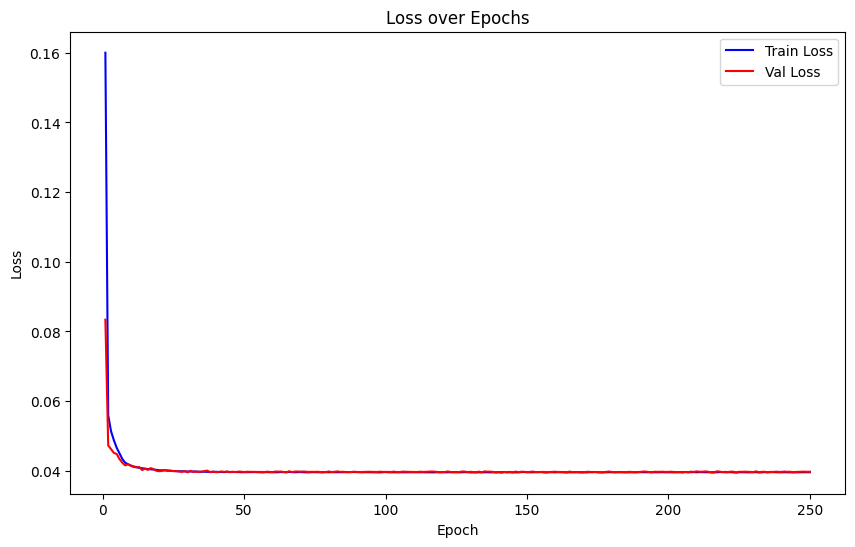

In [13]:
patch_size = 10
input_dim = patch_size**2
num_patches = int(150/patch_size)**2
print("masked patches: ", int(0.75*num_patches))
print("visible patches: ", num_patches - int(0.75*num_patches))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MAEViT(base="tiny", input_dim=input_dim, num_patches=num_patches, embed_dim=192).to(device)
model = nn.DataParallel(model)
criterion = nn.MSELoss()
print_trainable_parameters(model)

# 🔹 Optimizer & Loss
optimizer = optim.AdamW(model.parameters(), lr=2e-4, weight_decay=1e-6) # , weight_decay=1e-4 , weight_decay=1e-4
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

# Track metrics
train_losses, val_losses = [], []

# 🔹 Training Loop
num_epochs = 250
best_val_loss = 10000000000000.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0


    for images in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        images = images.to(device)
        optimizer.zero_grad()
        images = image_to_patches(images, 10)
        output, mask = model(images)
        masked_output = torch.gather(output, dim=1, index=mask.unsqueeze(-1).expand(-1, -1, input_dim))
        masked_patches = torch.gather(images, dim=1, index=mask.unsqueeze(-1).expand(-1, -1, input_dim))
        loss = criterion(masked_output.view(images.shape[0], -1), masked_patches.view(images.shape[0], -1))

        loss.backward()
        optimizer.step()

        # Statistics
        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)
    train_losses.append(train_loss)

    # Validation Step
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images = images.to(device)
            plt.imsave("original_image.png", images[0].cpu().detach().view(150, 150).numpy(), cmap="gray")

            optimizer.zero_grad()
            images = image_to_patches(images, 10)
            output, mask = model(images)
            masked_output = torch.gather(output, dim=1, index=mask.unsqueeze(-1).expand(-1, -1, input_dim))
            masked_patches = torch.gather(images, dim=1, index=mask.unsqueeze(-1).expand(-1, -1, input_dim))
            val_loss += criterion(masked_output.view(images.shape[0], -1), masked_patches.view(images.shape[0], -1)).item()

    val_loss = val_loss / len(val_loader)
    scheduler.step(val_loss) 

    val_losses.append(val_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")

    # Save Best Model
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_vit_MAE_model.pth")
        print("Model Saved (Best Validation loss)")

epochs = range(1, num_epochs + 1)
save_dir = "/kaggle/working/"

# Plot Loss
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_losses, label='Train Loss', color='blue')
plt.plot(epochs, val_losses, label='Val Loss', color='red')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.savefig(os.path.join(save_dir, 'MAE_Losses.png'))
plt.show()